In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Chỉ định từng đường dẫn

In [3]:
dataset = 'keypoint.csv'
model_save_path = 'keypoint_classifier.hdf5'

# Cài đặt số phân loại

In [4]:
NUM_CLASSES = 4

# Đọc dữ liệu đào tạo


In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Xây dựng mô hình

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1,114
Trainable params: 1,114
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Gọi lại điểm kiểm tra mô hình
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Gọi lại để dừng sớm
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Tổng hợp mô hình
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Đào tạo người mẫu

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/5 [=====>........................] - ETA: 2s - loss: 1.3472 - accuracy: 0.4766
Epoch 1: saving model to keypoint_classifier.hdf5
5/5 [==============================] - 1s 43ms/step - loss: 1.3388 - accuracy: 0.4516 - val_loss: 1.2800 - val_accuracy: 0.6557
Epoch 2/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.2926 - accuracy: 0.5156
Epoch 2: saving model to keypoint_classifier.hdf5
5/5 [==============================] - 0s 11ms/step - loss: 1.2728 - accuracy: 0.5832 - val_loss: 1.2499 - val_accuracy: 0.6667
Epoch 3/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.2616 - accuracy: 0.6172
Epoch 3: saving model to keypoint_classifier.hdf5
5/5 [==============================] - 0s 11ms/step - loss: 1.2446 - accuracy: 0.6289 - val_loss: 1.2205 - val_accuracy: 0.6667
Epoch 4/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.2324 - accuracy: 0.6328
Epoch 4: saving model to keypoint_classifier.hdf5
5/5 [==============================] - 0

In [13]:
# Đánh giá mô hình
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 1.0000


In [14]:
# Đang tải mô hình đã lưu
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Kiểm tra suy luận
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[4.1323019e-05 3.6363684e-08 9.9995863e-01 2.4618474e-11]
2


# Confix matrix

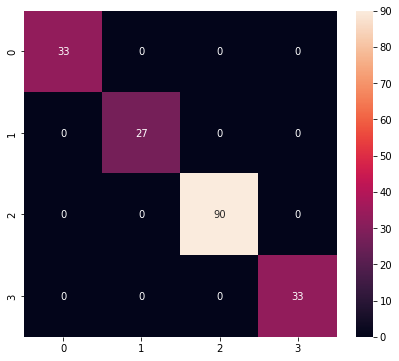

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        90
           3       1.00      1.00      1.00        33

    accuracy                           1.00       183
   macro avg       1.00      1.00      1.00       183
weighted avg       1.00      1.00      1.00       183



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite convert

In [17]:
# save weight
model.save(model_save_path, include_optimizer=False)

In [19]:
# convert tf
tflite_save_path = 'keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp932yfqlq/assets


INFO:tensorflow:Assets written to: /tmp/tmp932yfqlq/assets


6416

# Kiểm tra suy luận

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# I/o
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# Triển khai suy luận
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 432 µs, sys: 0 ns, total: 432 µs
Wall time: 313 µs


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.1323063e-05 3.6363751e-08 9.9995863e-01 2.4618472e-11]
2
